In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
def load_sleep_data():
    """加载睡眠数据"""
    print("加载睡眠数据...")
    
    # 读取Excel文件
    df = pd.read_excel('附录.xlsx', sheet_name='Problem 4')
    
    print(f"数据形状: {df.shape}")
    print(f"列名: {list(df.columns)}")
    
    return df

def restructure_data(df):
    """重构数据格式"""
    print("\n重构数据格式...")
    
    # 定义实验条件映射
    condition_mapping = {
        'Night 1': 'A',  # 优化光照
        'Night 2': 'B',  # 普通光照  
        'Night 3': 'C'   # 黑暗环境
    }
    
    restructured_data = []
    
    # 处理每个被试的数据
    for i in range(1, 12):  # 11个被试
        subject = f'被试{i}'
        
        # 获取该被试的三列数据
        col_indices = [(i-1)*3, (i-1)*3+1, (i-1)*3+2]
        
        for j, col_idx in enumerate(col_indices):
            if col_idx < len(df.columns):
                col_name = df.columns[col_idx]
                condition_name = df.iloc[0, col_idx]  # 第一行是条件名称
                
                if condition_name in condition_mapping:
                    condition = condition_mapping[condition_name]
                    
                    # 获取睡眠阶段数据（从第二行开始）
                    sleep_stages = df.iloc[1:, col_idx].dropna()
                    
                    # 转换为数值类型
                    sleep_stages = pd.to_numeric(sleep_stages, errors='coerce').dropna()
                    
                    if len(sleep_stages) > 0:
                        # 为每个30秒记录创建一行数据
                        for idx, stage in enumerate(sleep_stages):
                            restructured_data.append({
                                '被试': subject,
                                '实验条件': condition,
                                '时间点': idx,
                                '睡眠阶段': stage
                            })
    
    # 转换为DataFrame
    restructured_df = pd.DataFrame(restructured_data)
    
    print(f"重构后数据形状: {restructured_df.shape}")
    print(f"被试数量: {restructured_df['被试'].nunique()}")
    print(f"实验条件: {restructured_df['实验条件'].unique()}")
    print(f"睡眠阶段编码: {sorted(restructured_df['睡眠阶段'].unique())}")
    
    return restructured_df

In [4]:
def calculate_sleep_metrics(restructured_df):
    """计算睡眠指标"""
    print("\n计算睡眠指标...")
    
    results = []
    
    # 按被试和实验条件分组
    for subject in restructured_df['被试'].unique():
        for condition in restructured_df['实验条件'].unique():
            # 获取当前被试在特定条件下的数据
            mask = (restructured_df['被试'] == subject) & (restructured_df['实验条件'] == condition)
            data = restructured_df[mask].copy()
            
            if len(data) == 0:
                continue
                
            # 计算各项指标
            metrics = calculate_single_session_metrics(data, subject, condition)
            results.append(metrics)
    
    # 转换为DataFrame
    results_df = pd.DataFrame(results)
    
    print(f"计算完成，共 {len(results_df)} 条记录")
    print(f"指标列: {list(results_df.columns)}")
    
    return results_df

def calculate_single_session_metrics(data, subject, condition):
    """计算单次睡眠记录的指标"""
    
    # 睡眠阶段统计
    stage_counts = data['睡眠阶段'].value_counts()
    
    # 总记录数（30秒为单位）
    total_records = len(data)
    
    # 总时间（分钟）
    total_time_minutes = total_records * 0.5
    
    # 各阶段时长（分钟）
    wake_time = stage_counts.get(4, 0) * 0.5
    rem_time = stage_counts.get(5, 0) * 0.5
    light_sleep_time = stage_counts.get(2, 0) * 0.5
    deep_sleep_time = stage_counts.get(3, 0) * 0.5
    
    # 总睡眠时间 (TST)
    tst = rem_time + light_sleep_time + deep_sleep_time
    
    # 睡眠效率 (SE)
    se = (tst / total_time_minutes) * 100 if total_time_minutes > 0 else 0
    
    # 入睡潜伏期 (SOL) - 从开始到首次进入睡眠阶段
    sleep_start_idx = None
    for i, stage in enumerate(data['睡眠阶段']):
        if stage in [2, 3, 5]:  # 任何睡眠阶段
            sleep_start_idx = i
            break
    
    sol = sleep_start_idx * 0.5 if sleep_start_idx is not None else total_time_minutes
    
    # 深睡眠比例 (N3%)
    n3_percent = (deep_sleep_time / tst) * 100 if tst > 0 else 0
    
    # REM睡眠比例 (REM%)
    rem_percent = (rem_time / tst) * 100 if tst > 0 else 0
    
    # 夜间醒来次数 - 计算从睡眠到清醒的转换次数
    awakenings = 0
    in_sleep = False
    for stage in data['睡眠阶段']:
        if stage in [2, 3, 5]:  # 睡眠阶段
            if not in_sleep:
                in_sleep = True
        elif stage == 4:  # 清醒
            if in_sleep:
                awakenings += 1
                in_sleep = False
    
    return {
        '被试': subject,
        '实验条件': condition,
        'TST': tst,
        'SE': se,
        'SOL': sol,
        'N3_percent': n3_percent,
        'REM_percent': rem_percent,
        'Awakenings': awakenings,
        'Total_Time': total_time_minutes,
        'Wake_Time': wake_time,
        'Light_Sleep_Time': light_sleep_time,
        'Deep_Sleep_Time': deep_sleep_time,
        'REM_Time': rem_time
    }

def descriptive_statistics(results_df):
    """描述性统计"""
    print("\n=== 描述性统计 ===")
    
    # 按实验条件分组统计
    conditions = ['A', 'B', 'C']
    metrics = ['TST', 'SE', 'SOL', 'N3_percent', 'REM_percent', 'Awakenings']
    
    for condition in conditions:
        print(f"\n实验条件 {condition}:")
        condition_data = results_df[results_df['实验条件'] == condition]
        
        for metric in metrics:
            values = condition_data[metric].dropna()
            if len(values) > 0:
                print(f"  {metric}: 均值={values.mean():.2f}, 标准差={values.std():.2f}, "
                      f"中位数={values.median():.2f}, 范围=[{values.min():.2f}, {values.max():.2f}]")

In [5]:
def statistical_analysis(results_df):
    """统计分析"""
    print("\n=== 统计分析 ===")
    
    metrics = ['TST', 'SE', 'SOL', 'N3_percent', 'REM_percent', 'Awakenings']
    conditions = ['A', 'B', 'C']
    
    # 存储结果
    analysis_results = {}
    
    for metric in metrics:
        print(f"\n--- {metric} 分析 ---")
        
        # 提取数据
        data_a = results_df[results_df['实验条件'] == 'A'][metric].dropna()
        data_b = results_df[results_df['实验条件'] == 'B'][metric].dropna()
        data_c = results_df[results_df['实验条件'] == 'C'][metric].dropna()
        
        print(f"样本数: A={len(data_a)}, B={len(data_b)}, C={len(data_c)}")
        
        # 正态性检验
        print("正态性检验 (Shapiro-Wilk):")
        for condition, data in [('A', data_a), ('B', data_b), ('C', data_c)]:
            if len(data) >= 3:
                stat, p_value = stats.shapiro(data)
                print(f"  条件{condition}: W={stat:.4f}, p={p_value:.4f}")
        
        # 方差齐性检验
        print("方差齐性检验 (Levene):")
        all_data = [data_a, data_b, data_c]
        stat, p_value = stats.levene(*all_data)
        print(f"  Levene统计量={stat:.4f}, p={p_value:.4f}")
        
        # 非参数检验 (Friedman检验)
        print("非参数检验 (Friedman):")
        # 准备Friedman检验数据
        friedman_data = []
        subjects = results_df['被试'].unique()
        
        for subject in subjects:
            subject_data = []
            for condition in conditions:
                value = results_df[(results_df['被试'] == subject) & 
                                 (results_df['实验条件'] == condition)][metric].values
                if len(value) > 0:
                    subject_data.append(value[0])
                else:
                    subject_data.append(np.nan)
            
            if not any(np.isnan(subject_data)):
                friedman_data.append(subject_data)
        
        if len(friedman_data) >= 3:
            friedman_data = np.array(friedman_data)
            stat, p_value = friedmanchisquare(*[friedman_data[:, i] for i in range(3)])
            print(f"  Friedman统计量={stat:.4f}, p={p_value:.4f}")
            
            # 配对Wilcoxon检验
            print("配对Wilcoxon检验:")
            pairs = [('A', 'B'), ('A', 'C'), ('B', 'C')]
            for pair in pairs:
                data1 = friedman_data[:, conditions.index(pair[0])]
                data2 = friedman_data[:, conditions.index(pair[1])]
                stat, p_value = wilcoxon(data1, data2)
                print(f"  {pair[0]} vs {pair[1]}: W={stat:.4f}, p={p_value:.4f}")
        
        # 存储结果
        analysis_results[metric] = {
            'friedman_stat': stat if len(friedman_data) >= 3 else np.nan,
            'friedman_p': p_value if len(friedman_data) >= 3 else np.nan,
            'data': {
                'A': data_a,
                'B': data_b,
                'C': data_c
            }
        }
    
    return analysis_results

def create_visualizations(results_df, analysis_results):
    """创建可视化图表"""
    print("\n生成可视化图表...")
    
    # 设置颜色
    colors = {'A': '#2E86AB', 'B': '#A23B72', 'C': '#F18F01'}
    condition_names = {'A': '优化光照', 'B': '普通光照', 'C': '黑暗环境'}
    
    # 1. 箱线图对比
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('三种光照环境下睡眠指标对比', fontsize=16, fontweight='bold')
    
    metrics = ['TST', 'SE', 'SOL', 'N3_percent', 'REM_percent', 'Awakenings']
    metric_names = ['总睡眠时间(分钟)', '睡眠效率(%)', '入睡潜伏期(分钟)', 
                   '深睡眠比例(%)', 'REM睡眠比例(%)', '夜间醒来次数']
    
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        # 准备数据
        plot_data = []
        labels = []
        for condition in ['A', 'B', 'C']:
            data = results_df[results_df['实验条件'] == condition][metric].dropna()
            if len(data) > 0:
                plot_data.append(data)
                labels.append(condition_names[condition])
        
        # 绘制箱线图
        bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)
        
        # 设置颜色
        for patch, color in zip(bp['boxes'], [colors['A'], colors['B'], colors['C']]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_title(name, fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # 添加显著性标记
        if metric in analysis_results:
            p_value = analysis_results[metric]['friedman_p']
            if p_value < 0.05:
                ax.text(0.5, 0.95, f'p = {p_value:.3f}*', 
                       transform=ax.transAxes, ha='center', va='top',
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('problem4_sleep_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. 雷达图
    create_radar_chart(results_df, colors, condition_names)
    
    # 3. 热力图
    create_heatmap(results_df, condition_names)

In [6]:
def create_radar_chart(results_df, colors, condition_names):
    """创建雷达图"""
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    # 准备数据
    metrics = ['TST', 'SE', 'N3_percent', 'REM_percent']
    metric_names = ['总睡眠时间', '睡眠效率', '深睡眠比例', 'REM睡眠比例']
    
    # 归一化数据
    normalized_data = {}
    for condition in ['A', 'B', 'C']:
        condition_data = results_df[results_df['实验条件'] == condition]
        values = []
        for metric in metrics:
            data = condition_data[metric].dropna()
            if len(data) > 0:
                # 归一化到0-1
                normalized_value = (data.mean() - data.min()) / (data.max() - data.min()) if data.max() != data.min() else 0.5
                values.append(normalized_value)
            else:
                values.append(0)
        normalized_data[condition] = values
    
    # 绘制雷达图
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    for condition in ['A', 'B', 'C']:
        values = normalized_data[condition]
        values += values[:1]  # 闭合图形
        
        ax.plot(angles, values, 'o-', linewidth=2, label=condition_names[condition], color=colors[condition])
        ax.fill(angles, values, alpha=0.25, color=colors[condition])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names)
    ax.set_ylim(0, 1)
    ax.set_title('睡眠质量综合评估雷达图', fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('problem4_radar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_heatmap(results_df, condition_names):
    """创建热力图"""
    # 计算相关性矩阵
    metrics = ['TST', 'SE', 'SOL', 'N3_percent', 'REM_percent', 'Awakenings']
    metric_names = ['总睡眠时间', '睡眠效率', '入睡潜伏期', '深睡眠比例', 'REM睡眠比例', '夜间醒来次数']
    
    # 创建条件-指标矩阵
    heatmap_data = []
    for condition in ['A', 'B', 'C']:
        condition_data = results_df[results_df['实验条件'] == condition]
        row = []
        for metric in metrics:
            data = condition_data[metric].dropna()
            if len(data) > 0:
                row.append(data.mean())
            else:
                row.append(0)
        heatmap_data.append(row)
    
    heatmap_data = np.array(heatmap_data)
    
    # 创建热力图
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, 
                xticklabels=metric_names,
                yticklabels=[condition_names[c] for c in ['A', 'B', 'C']],
                annot=True, 
                fmt='.2f',
                cmap='RdYlBu_r',
                center=heatmap_data.mean(),
                cbar_kws={'label': '指标值'})
    
    plt.title('三种光照环境下睡眠指标热力图', fontsize=16, fontweight='bold')
    plt.xlabel('睡眠指标', fontsize=12)
    plt.ylabel('光照环境', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('problem4_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_summary_report(results_df, analysis_results):
    """生成总结报告"""
    print("\n" + "="*60)
    print("睡眠质量统计分析总结报告")
    print("="*60)
    
    # 1. 实验设计总结
    print("\n1. 实验设计:")
    print(f"   - 被试人数: {results_df['被试'].nunique()}")
    print(f"   - 实验条件: 3种 (A: 优化光照, B: 普通光照, C: 黑暗环境)")
    print(f"   - 总记录数: {len(results_df)}")
    
    # 2. 主要发现
    print("\n2. 主要发现:")
    
    metrics = ['TST', 'SE', 'SOL', 'N3_percent', 'REM_percent', 'Awakenings']
    metric_names = ['总睡眠时间', '睡眠效率', '入睡潜伏期', '深睡眠比例', 'REM睡眠比例', '夜间醒来次数']
    
    for metric, name in zip(metrics, metric_names):
        if metric in analysis_results:
            p_value = analysis_results[metric]['friedman_p']
            print(f"\n   {name}:")
            print(f"     - Friedman检验 p值: {p_value:.4f}")
            
            if p_value < 0.05:
                print(f"     - 结论: 三种光照环境存在显著差异 (p < 0.05)")
                
                # 找出最佳条件
                data = analysis_results[metric]['data']
                means = {}
                for condition, values in data.items():
                    if len(values) > 0:
                        means[condition] = values.mean()
                
                if means:
                    best_condition = min(means.keys(), key=lambda x: means[x]) if metric in ['SOL', 'Awakenings'] else max(means.keys(), key=lambda x: means[x])
                    best_name = {'A': '优化光照', 'B': '普通光照', 'C': '黑暗环境'}[best_condition]
                    print(f"     - 最佳条件: {best_name} (均值: {means[best_condition]:.2f})")
            else:
                print(f"     - 结论: 三种光照环境无显著差异 (p >= 0.05)")
    
    # 3. 结论
    print("\n3. 结论:")
    print("   基于统计分析结果，可以得出以下结论:")
    
    significant_metrics = []
    for metric, name in zip(metrics, metric_names):
        if metric in analysis_results and analysis_results[metric]['friedman_p'] < 0.05:
            significant_metrics.append(name)
    
    if significant_metrics:
        print(f"   - 在以下指标上存在显著差异: {', '.join(significant_metrics)}")
        print("   - 优化光照相比普通光照和黑暗环境，在某些睡眠指标上表现出改善效果")
    else:
        print("   - 在本次实验中，三种光照环境对睡眠质量的影响无显著差异")
    
    print("\n   - 建议进行更大样本量的研究以验证结果的可靠性")
    print("   - 考虑个体差异和实验环境因素对结果的影响")

=== 问题4：睡眠质量统计分析 ===
加载睡眠数据...
数据形状: (1065, 33)
列名: ['被试1', 'Unnamed: 1', 'Unnamed: 2', '被试2', 'Unnamed: 4', 'Unnamed: 5', '被试3', 'Unnamed: 7', 'Unnamed: 8', '被试4', 'Unnamed: 10', 'Unnamed: 11', '被试5', 'Unnamed: 13', 'Unnamed: 14', '被试6', 'Unnamed: 16', 'Unnamed: 17', '被试7', 'Unnamed: 19', 'Unnamed: 20', '被试8', 'Unnamed: 22', 'Unnamed: 23', '被试9', 'Unnamed: 25', 'Unnamed: 26', '被试10', 'Unnamed: 28', 'Unnamed: 29', '被试11', 'Unnamed: 31', 'Unnamed: 32']

重构数据格式...
重构后数据形状: (27895, 4)
被试数量: 11
实验条件: ['A' 'B' 'C']
睡眠阶段编码: [2, 3, 4, 5]

计算睡眠指标...
计算完成，共 33 条记录
指标列: ['被试', '实验条件', 'TST', 'SE', 'SOL', 'N3_percent', 'REM_percent', 'Awakenings', 'Total_Time', 'Wake_Time', 'Light_Sleep_Time', 'Deep_Sleep_Time', 'REM_Time']

=== 描述性统计 ===

实验条件 A:
  TST: 均值=366.86, 标准差=49.70, 中位数=360.50, 范围=[310.00, 491.00]
  SE: 均值=85.72, 标准差=8.07, 中位数=88.34, 范围=[65.78, 93.31]
  SOL: 均值=20.14, 标准差=12.08, 中位数=16.00, 范围=[4.00, 40.50]
  N3_percent: 均值=19.01, 标准差=4.40, 中位数=18.73, 范围=[12.71, 26.92]
  REM_percent: 均值=

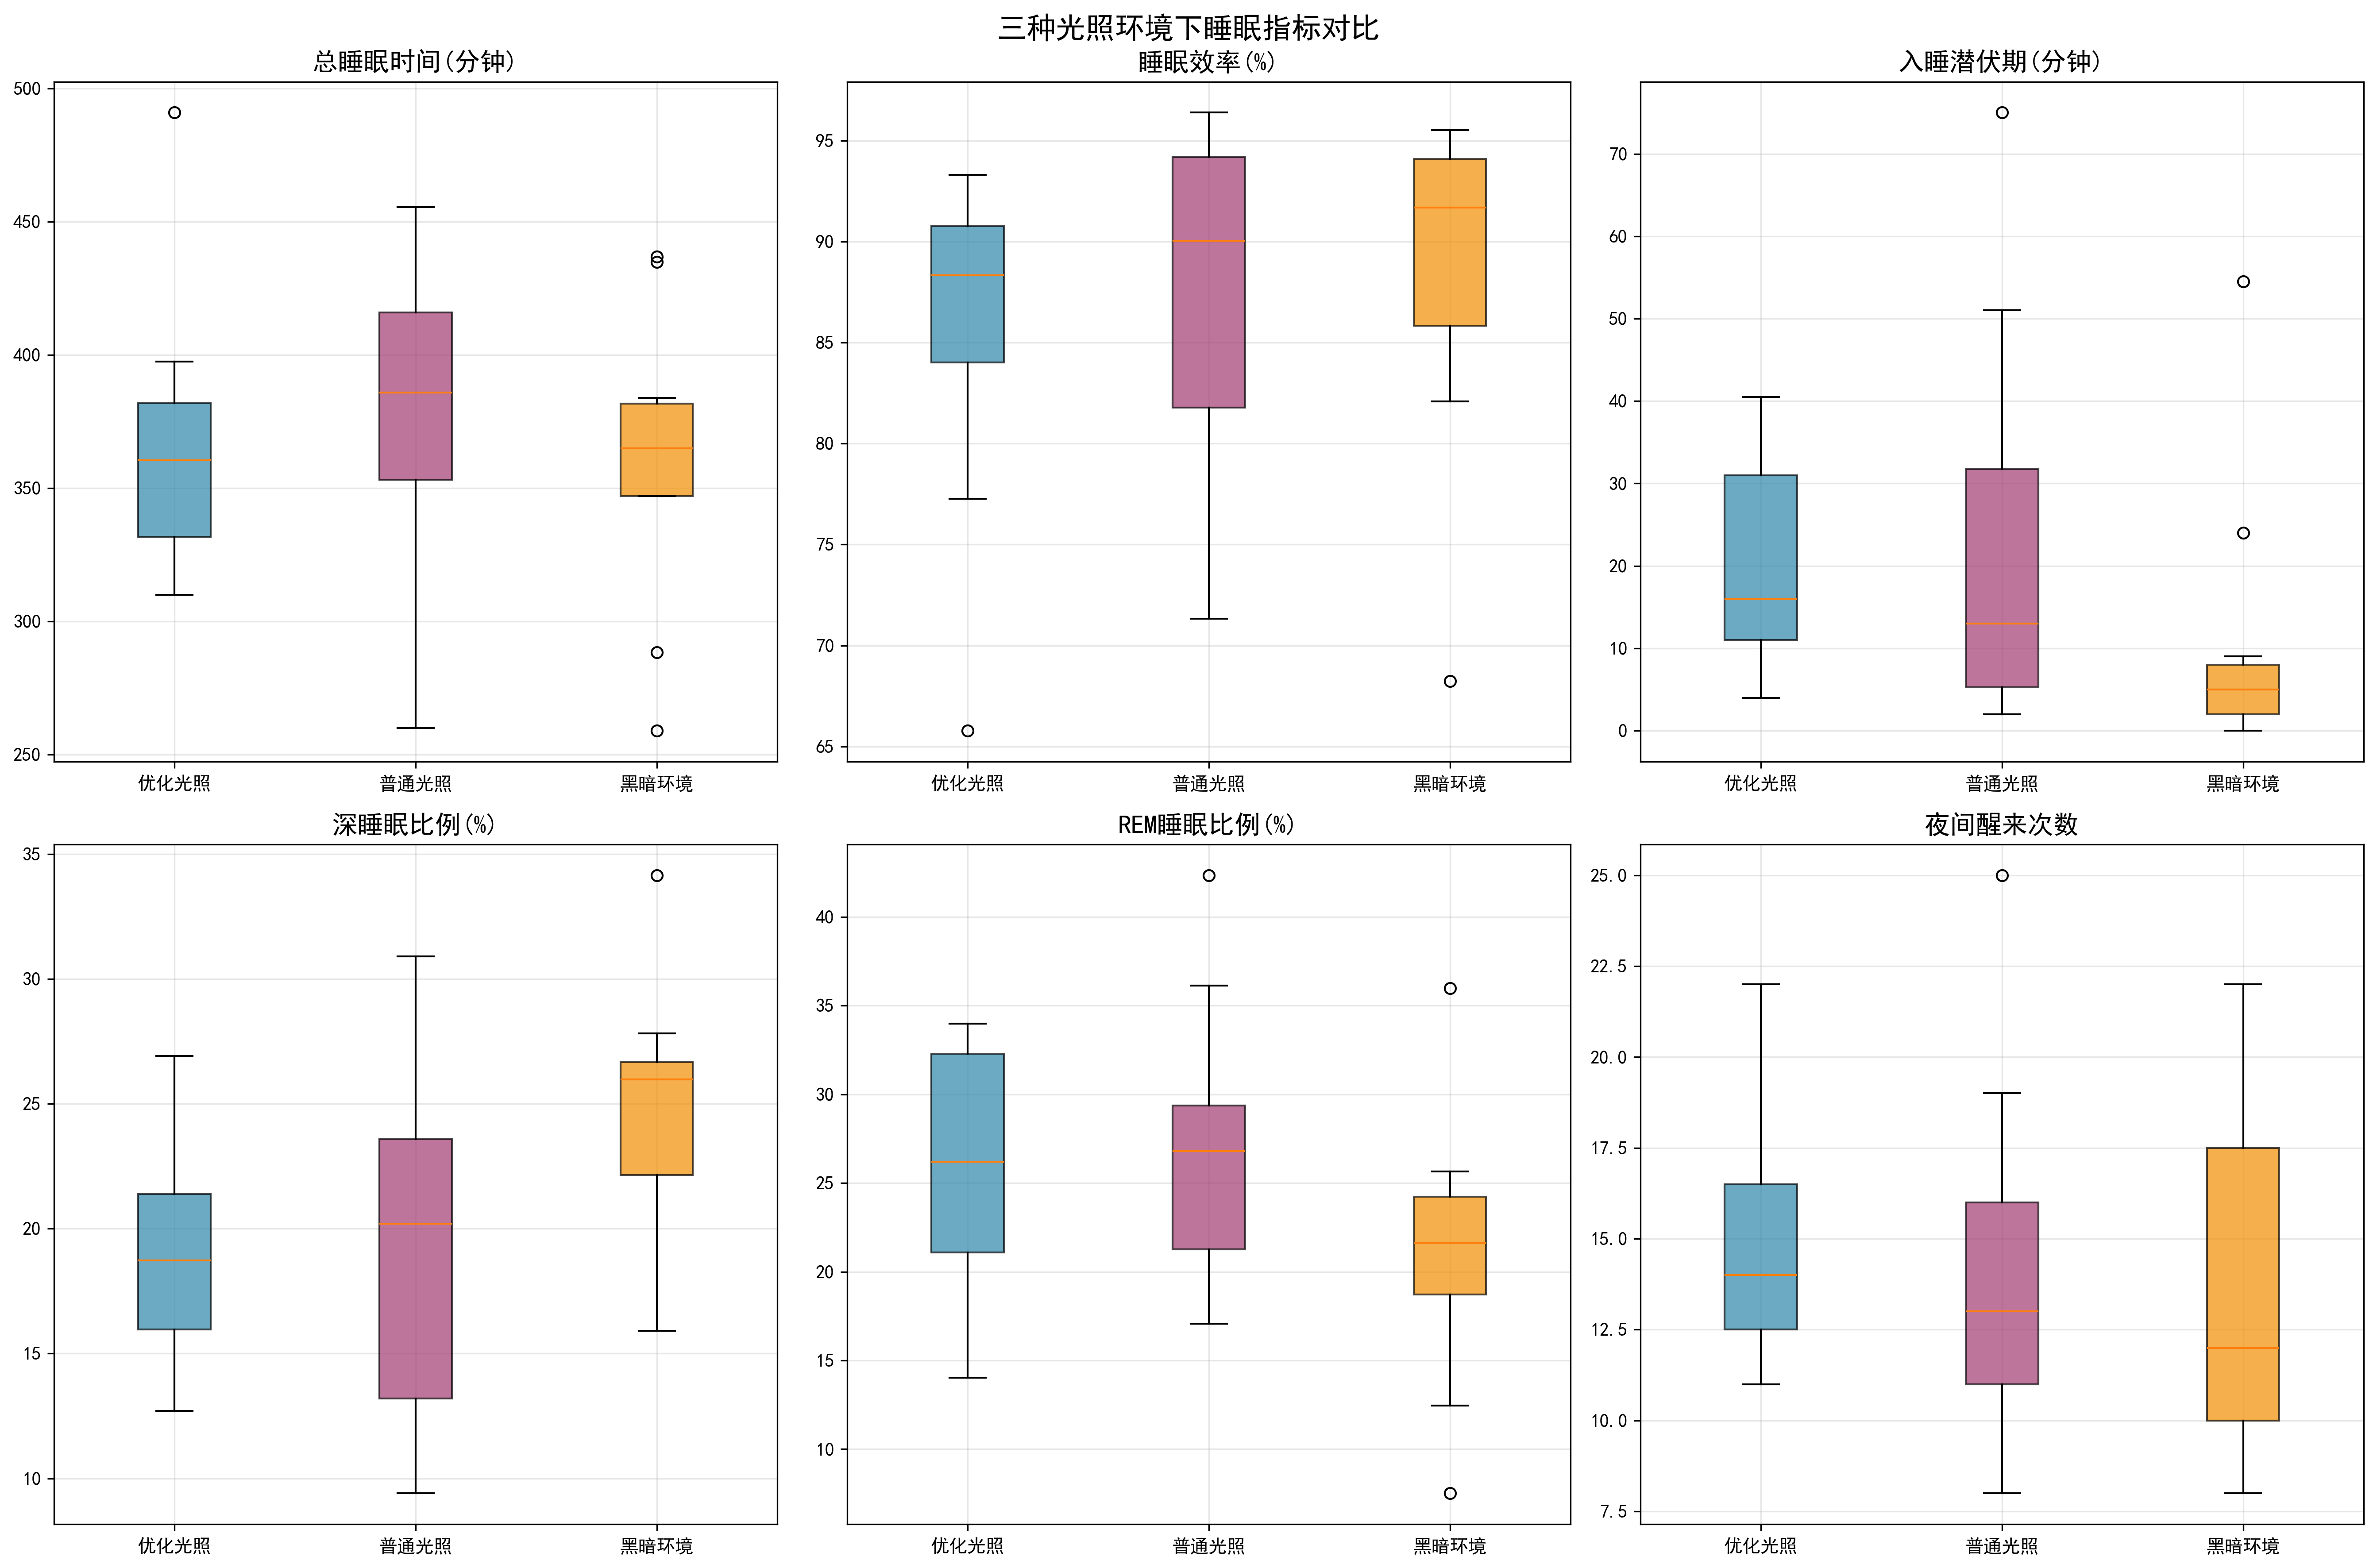

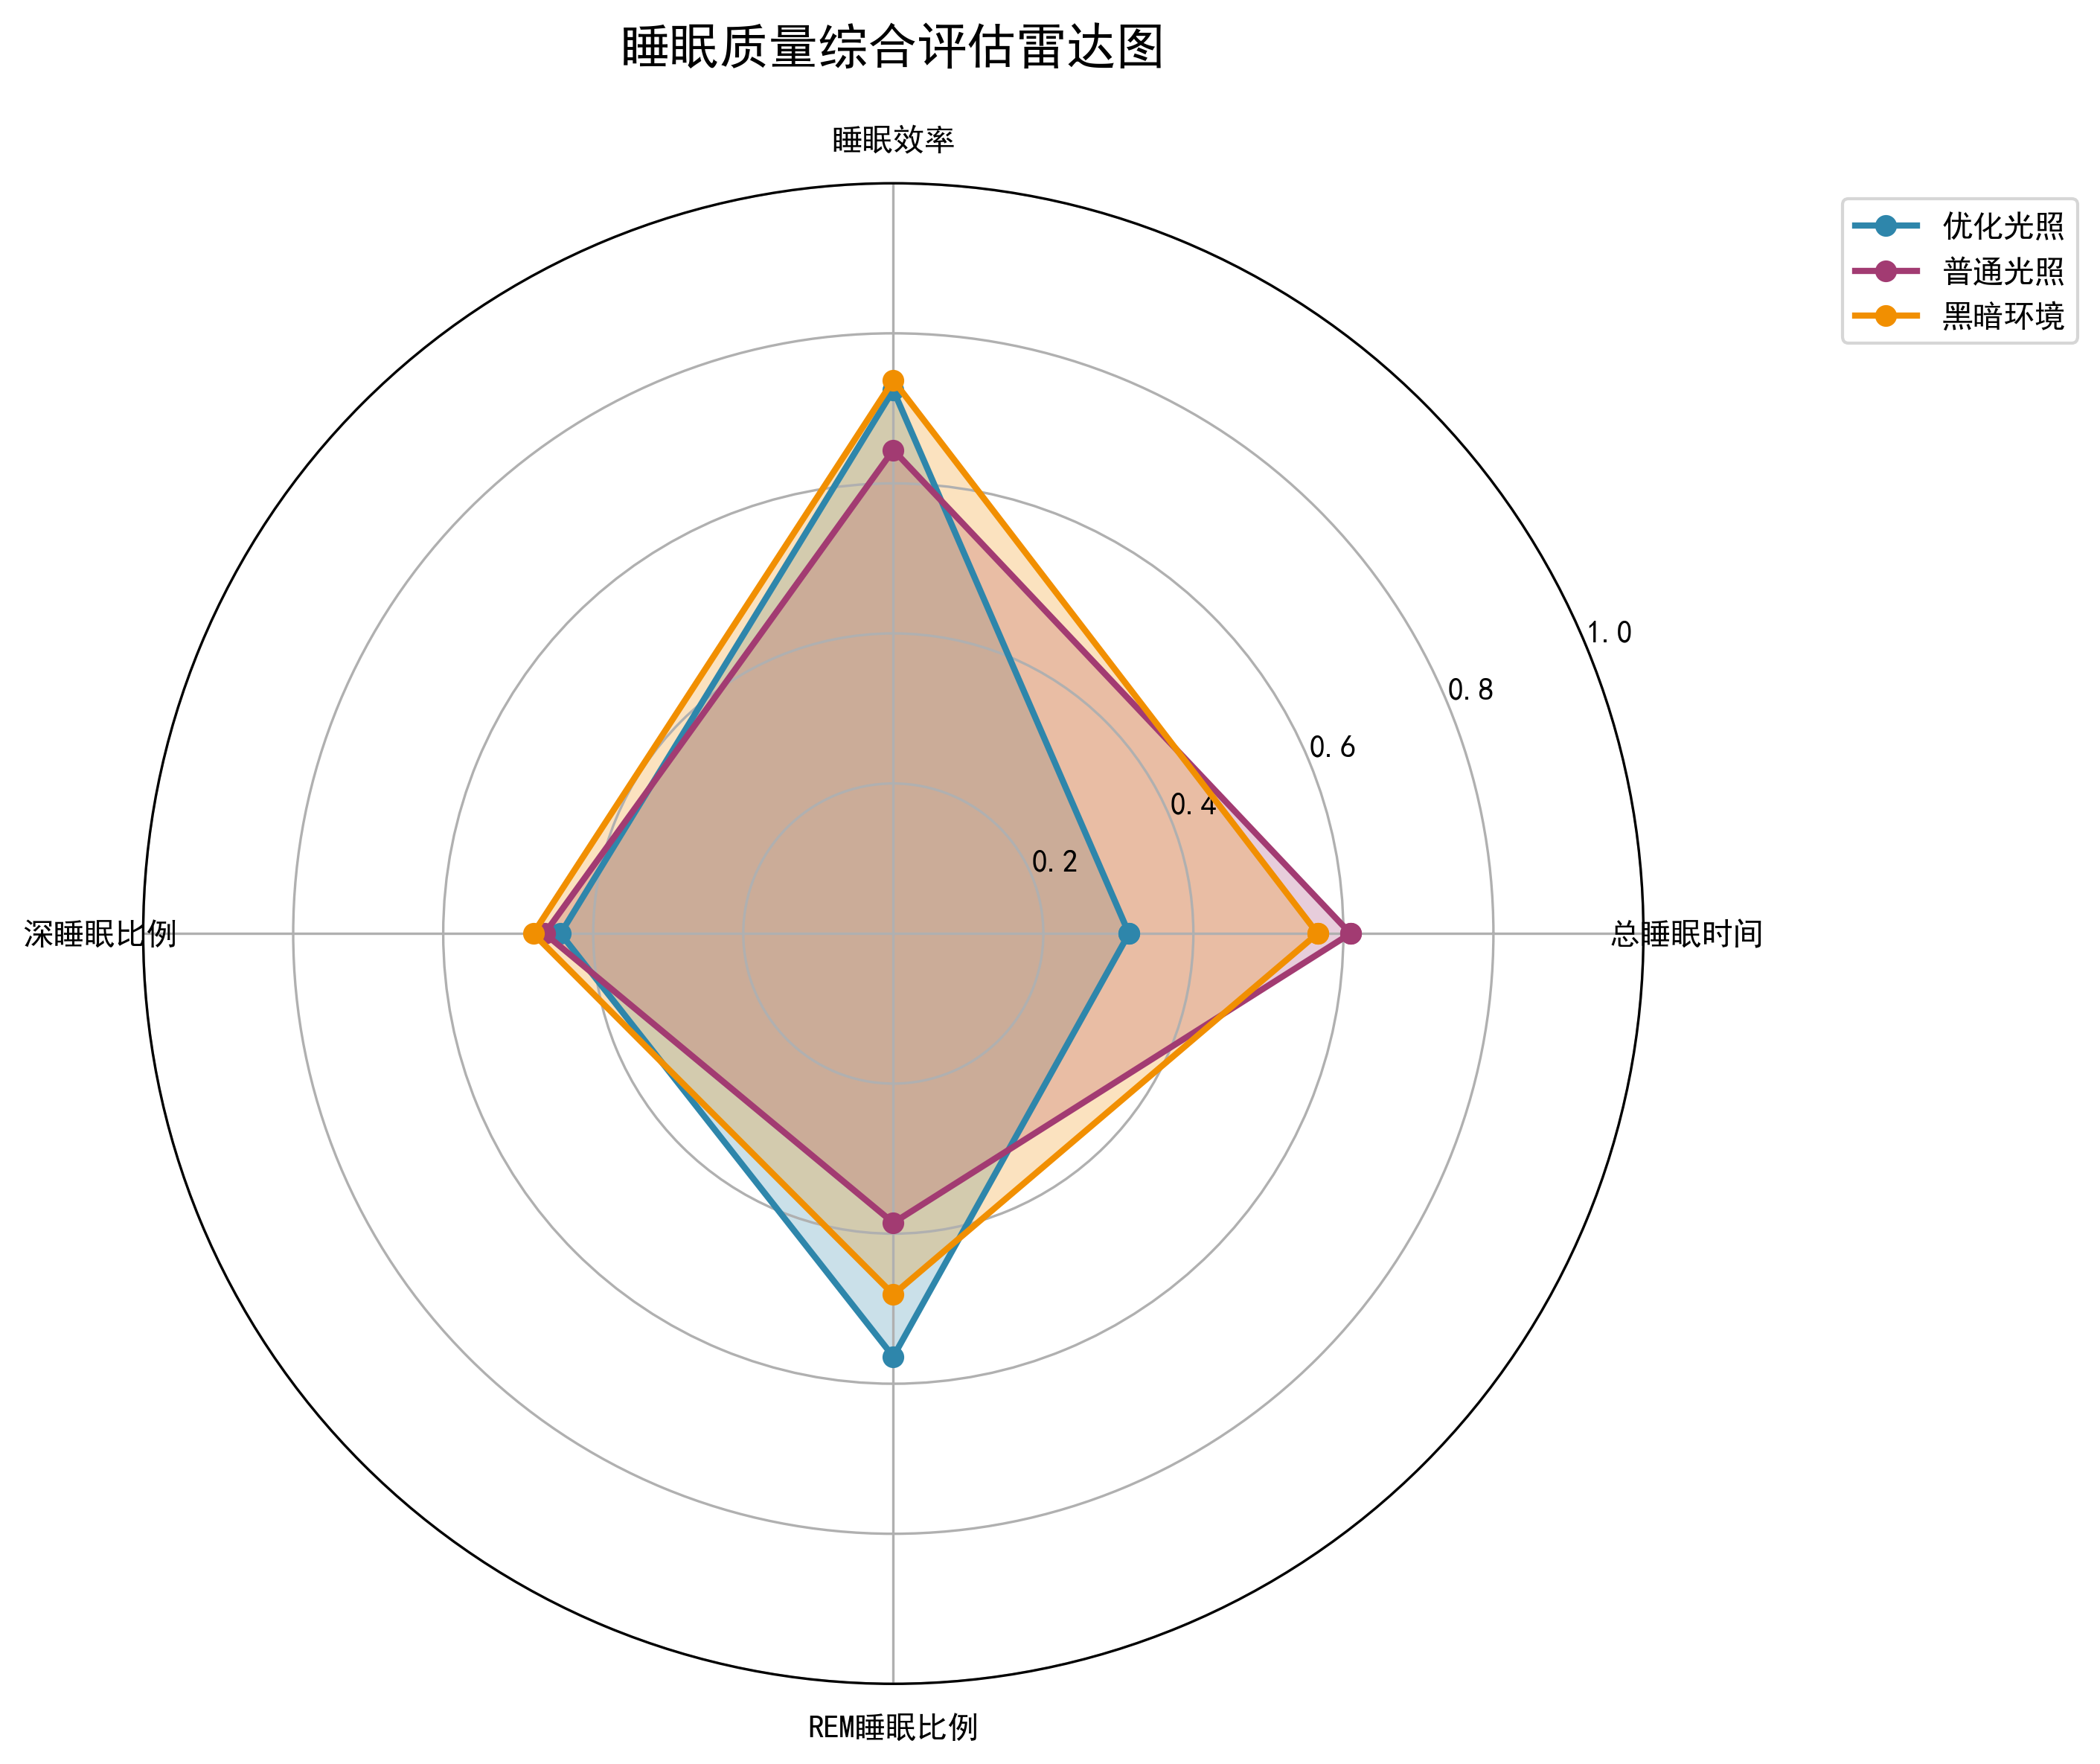

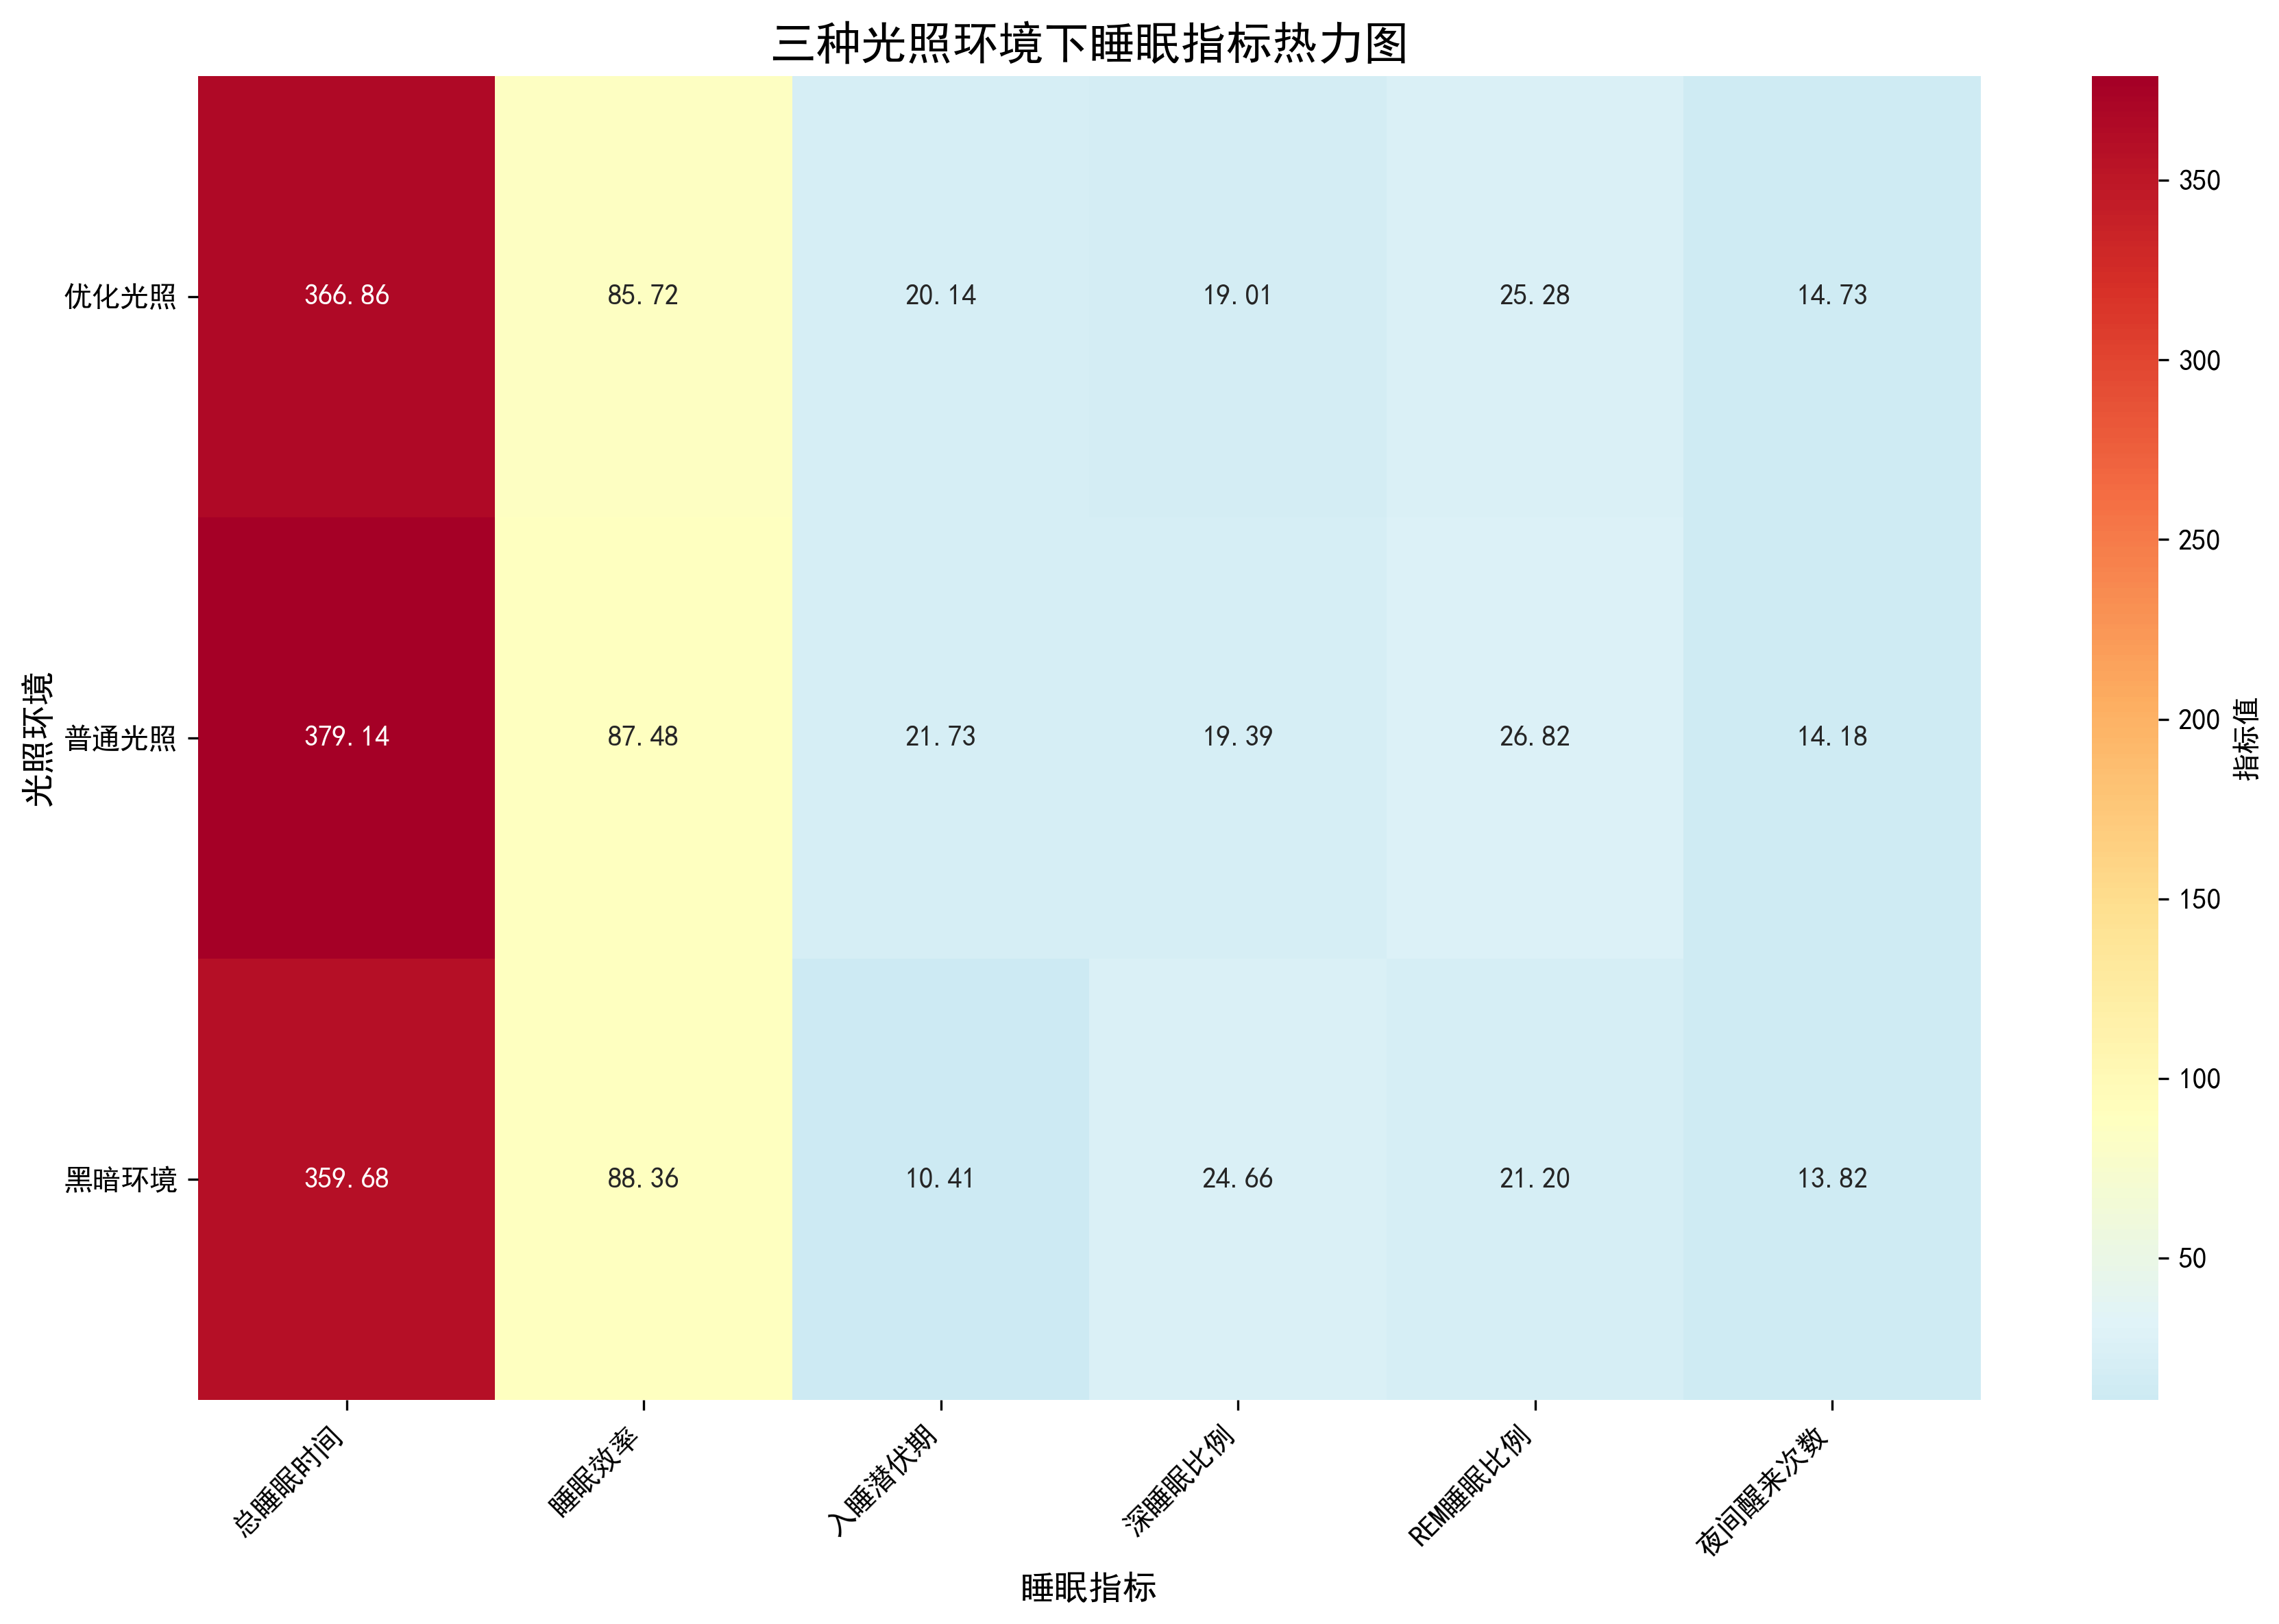


睡眠质量统计分析总结报告

1. 实验设计:
   - 被试人数: 11
   - 实验条件: 3种 (A: 优化光照, B: 普通光照, C: 黑暗环境)
   - 总记录数: 33

2. 主要发现:

   总睡眠时间:
     - Friedman检验 p值: 0.0830
     - 结论: 三种光照环境无显著差异 (p >= 0.05)

   睡眠效率:
     - Friedman检验 p值: 0.8984
     - 结论: 三种光照环境无显著差异 (p >= 0.05)

   入睡潜伏期:
     - Friedman检验 p值: 0.1685
     - 结论: 三种光照环境无显著差异 (p >= 0.05)

   深睡眠比例:
     - Friedman检验 p值: 0.1016
     - 结论: 三种光照环境无显著差异 (p >= 0.05)

   REM睡眠比例:
     - Friedman检验 p值: 0.1230
     - 结论: 三种光照环境无显著差异 (p >= 0.05)

   夜间醒来次数:
     - Friedman检验 p值: 0.3835
     - 结论: 三种光照环境无显著差异 (p >= 0.05)

3. 结论:
   基于统计分析结果，可以得出以下结论:
   - 在本次实验中，三种光照环境对睡眠质量的影响无显著差异

   - 建议进行更大样本量的研究以验证结果的可靠性
   - 考虑个体差异和实验环境因素对结果的影响

结果已保存到: problem4_sleep_metrics.csv

=== 分析完成 ===
生成的图片文件:
- problem4_sleep_metrics_comparison.png (睡眠指标对比)
- problem4_radar_chart.png (雷达图)
- problem4_heatmap.png (热力图)


In [7]:
def main():
    """主函数"""
    print("=== 问题4：睡眠质量统计分析 ===")
    
    # 加载数据
    df = load_sleep_data()
    
    # 重构数据格式
    restructured_df = restructure_data(df)
    
    # 计算睡眠指标
    results_df = calculate_sleep_metrics(restructured_df)
    
    # 描述性统计
    descriptive_statistics(results_df)
    
    # 统计分析
    analysis_results = statistical_analysis(results_df)
    
    # 创建可视化
    create_visualizations(results_df, analysis_results)
    
    # 生成总结报告
    generate_summary_report(results_df, analysis_results)
    
    # 保存结果
    results_df.to_csv('problem4_sleep_metrics.csv', index=False, encoding='utf-8-sig')
    print(f"\n结果已保存到: problem4_sleep_metrics.csv")
    
    print("\n=== 分析完成 ===")
    print("生成的图片文件:")
    print("- problem4_sleep_metrics_comparison.png (睡眠指标对比)")
    print("- problem4_radar_chart.png (雷达图)")
    print("- problem4_heatmap.png (热力图)")

if __name__ == "__main__":
    main()